# Image features exercise
We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

## Load data
Similar to previous exercises, we will load CIFAR-10 data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.datasets import cifar10  

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# subsample the data
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask].astype('float64')
y_val = y_train[mask]
mask = range(num_training)
X_train = X_train[mask].astype('float64')
y_train = y_train[mask]
mask = range(num_test)
X_test = X_test[mask].astype('float64')
y_test = y_test[mask]

print(X_train.shape, X_val.shape, X_test.shape)

Using TensorFlow backend.


(49000, 32, 32, 3) (1000, 32, 32, 3) (1000, 32, 32, 3)


## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [2]:
from features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [3]:
from classifiers import LinearSVM

learning_rates = [1e-8, 1e-7, 2e-7]
regularization_strengths = [5e3, 5e4, 5e5, 5e6]

results = {}
best_val = -1
best_svm = None

for lr in learning_rates:
    for reg in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, learning_rate=lr, reg=reg, num_iters=1000,
                      batch_size=200, verbose=False)
        train_acc = np.mean(svm.predict(X_train_feats) == y_train)
        val_acc = np.mean(svm.predict(X_val_feats) == y_val)
        results[(lr, reg)] = (train_acc, val_acc)
        if val_acc > best_val:
            best_val = val_acc
            best_svm = svm

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

lr 1.000000e-08 reg 5.000000e+03 train accuracy: 0.110959 val accuracy: 0.104000
lr 1.000000e-08 reg 5.000000e+04 train accuracy: 0.089918 val accuracy: 0.078000
lr 1.000000e-08 reg 5.000000e+05 train accuracy: 0.414061 val accuracy: 0.424000
lr 1.000000e-08 reg 5.000000e+06 train accuracy: 0.406245 val accuracy: 0.412000
lr 1.000000e-07 reg 5.000000e+03 train accuracy: 0.099122 val accuracy: 0.089000
lr 1.000000e-07 reg 5.000000e+04 train accuracy: 0.415633 val accuracy: 0.416000
lr 1.000000e-07 reg 5.000000e+05 train accuracy: 0.391653 val accuracy: 0.379000
lr 1.000000e-07 reg 5.000000e+06 train accuracy: 0.305408 val accuracy: 0.318000
lr 2.000000e-07 reg 5.000000e+03 train accuracy: 0.179408 val accuracy: 0.183000
lr 2.000000e-07 reg 5.000000e+04 train accuracy: 0.413898 val accuracy: 0.404000
lr 2.000000e-07 reg 5.000000e+05 train accuracy: 0.411245 val accuracy: 0.420000
lr 2.000000e-07 reg 5.000000e+06 train accuracy: 0.095388 val accuracy: 0.091000
best validation accuracy ach

In [4]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy) # 특징 추출 없이 훈련했을 때는 정확도가 0.375였다.

0.429


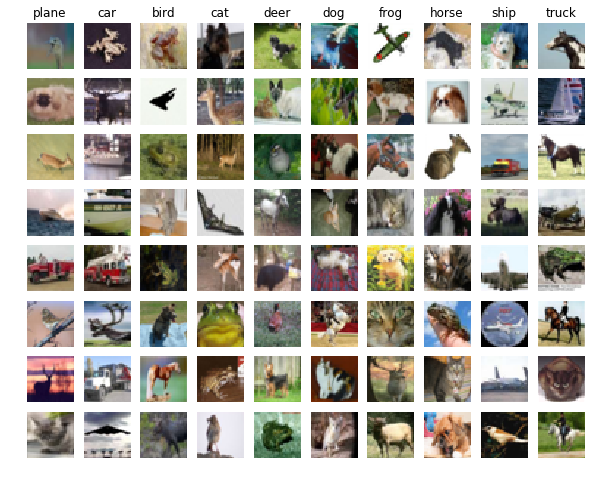

In [5]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".
plt.rcParams['figure.figsize'] = (10.0, 8.0)
examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [6]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [7]:
from classifiers import TwoLayerNet

input_size = X_train_feats.shape[1]
num_classes = 10

hidden_size = (400, 600)
learning_rate = (0.5, 1., 1.5)
reg = (1e-5, 1e-4, 1e-3)

best_net = None 
best_val_acc = 0
best_params = ()
best_stats = None

for h in hidden_size:
    print("===========")
    for l in learning_rate:
        print("-----------")
        for r in reg:
            net = TwoLayerNet(input_size, h, num_classes)
            stats = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=1000, batch_size=200,
                                learning_rate=l, learning_rate_decay=0.95, reg=r, verbose=False)
            print('hidden_size: %d, learning_rate: %.2f, reg: %.2e' %(h, l, r))
            val_acc = (net.predict(X_val_feats) == y_val).mean()
            print('Validation accuracy: %f \n' %val_acc)

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_net = net
                best_stats = stats
                best_params = (h, l, r)

val_acc = (best_net.predict(X_val_feats) == y_val).mean()
print('Best validation accuracy: ', val_acc)
print('hidden_size: %d, learning_rate: %e, reg: %.2f' %(best_params[0], best_params[1], best_params[2]))

-----------
hidden_size: 400, learning_rate: 0.50, reg: 1.00e-05
Validation accuracy: 0.562000 

hidden_size: 400, learning_rate: 0.50, reg: 1.00e-04
Validation accuracy: 0.581000 

hidden_size: 400, learning_rate: 0.50, reg: 1.00e-03
Validation accuracy: 0.586000 

-----------
hidden_size: 400, learning_rate: 1.00, reg: 1.00e-05
Validation accuracy: 0.576000 

hidden_size: 400, learning_rate: 1.00, reg: 1.00e-04
Validation accuracy: 0.564000 

hidden_size: 400, learning_rate: 1.00, reg: 1.00e-03
Validation accuracy: 0.554000 

-----------
hidden_size: 400, learning_rate: 1.50, reg: 1.00e-05
Validation accuracy: 0.527000 

hidden_size: 400, learning_rate: 1.50, reg: 1.00e-04
Validation accuracy: 0.551000 

hidden_size: 400, learning_rate: 1.50, reg: 1.00e-03
Validation accuracy: 0.569000 

-----------
hidden_size: 600, learning_rate: 0.50, reg: 1.00e-05
Validation accuracy: 0.564000 

hidden_size: 600, learning_rate: 0.50, reg: 1.00e-04
Validation accuracy: 0.568000 

hidden_size: 600,

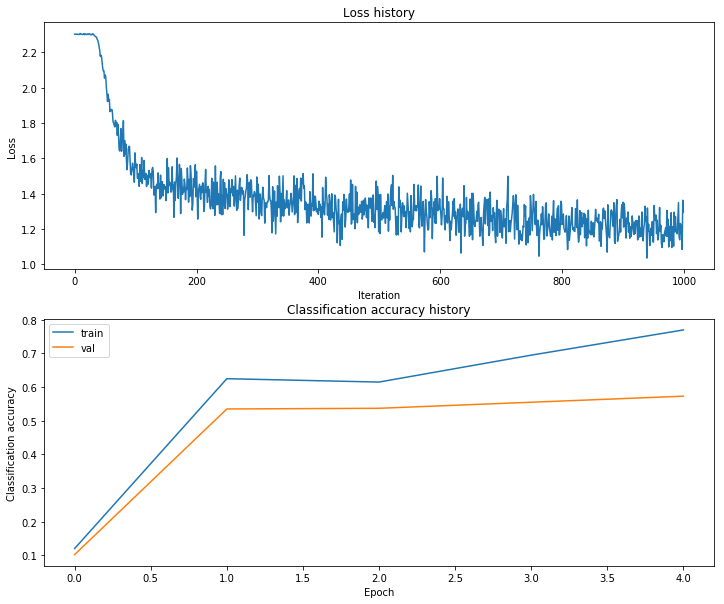

In [8]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 1, 1)
plt.plot(best_stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(best_stats['train_acc_history'], label='train')
plt.plot(best_stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

In [9]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print(test_acc)

0.565
